In [1]:
import pandas as pd
import hvplot.pandas
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
ICE_USDCNY_1D = Path("Resources/ICE_USDCNY_1D.csv")

In [3]:
usdcny_1D = pd.read_csv(
    ICE_USDCNY_1D,
    index_col="time",
    parse_dates=True,
)
usdcny_1D = usdcny_1D.dropna()
print('Shape of data', usdcny_1D.shape)
usdcny_1D.head()

Shape of data (10919, 5)


,open,high,low,close,Volume
time,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [4]:
usdcny_1D = usdcny_1D.rename_axis("Date")
usdcny_1D.head()

,open,high,low,close,Volume
Date,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [5]:
usdcny_1D = usdcny_1D[["close"]]

usdcny_1D.tail()

,close
Date,
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795
2024-03-13,7.1856
2024-03-14,7.1927


<Axes: xlabel='Date'>

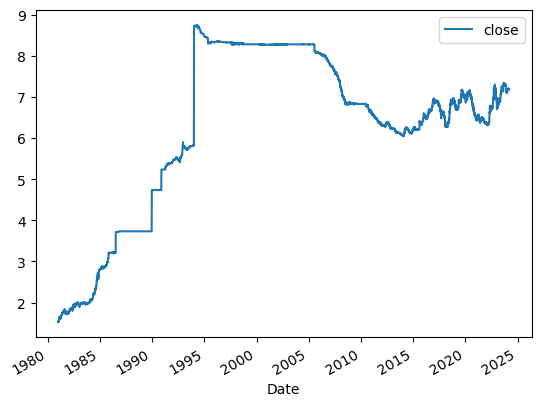

In [6]:
usdcny_1D.plot()

In [7]:
# Post-currency devaluation August 2015

start_date = '2015-08-01'
end_date = '2024-03-14'

# Boolean indexing to select rows within the specified date range
usdcny_post2015 = usdcny_1D[(usdcny_1D.index >= start_date) & (usdcny_1D.index <= end_date)]
usdcny_post2015

,close
Date,
2015-08-03,6.2087
2015-08-04,6.2085
2015-08-05,6.2095
2015-08-06,6.2095
2015-08-07,6.2085
...,...
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795


<Axes: xlabel='Date'>

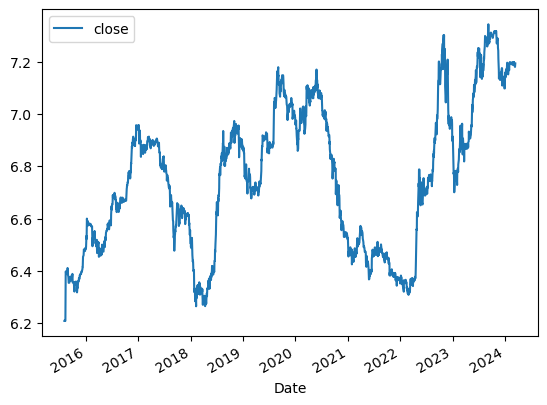

In [8]:
usdcny_post2015.plot()

## Check for Stationarity

In [9]:
# Function that checks for stationarity
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [10]:
check_stationarity(usdcny_post2015)

The series is NOT stationary


## Figure out Order for ARIMA Model

In [11]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(
    usdcny_post2015, 
    trace=True,
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11689.942, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11693.337, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11691.411, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11691.412, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11693.995, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11689.412, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.476 seconds


In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
# Assigning frequency for the model to recognize how to plot dates
usdcny_post2015.index = pd.DatetimeIndex(usdcny_post2015.index).to_period('D')

In [14]:
usdcny_post2015 = usdcny_post2015.asfreq('d')

In [15]:
usdcny_post2015.index

PeriodIndex(['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
             '2015-08-07', '2015-08-10', '2015-08-11', '2015-08-12',
             '2015-08-13', '2015-08-14',
             ...
             '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
             '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
             '2024-03-13', '2024-03-14'],
            dtype='period[D]', name='Date', length=2248)

## Split Data into Training and Testing

In [16]:
print(usdcny_post2015.shape)
train = usdcny_post2015.iloc[:-30]
test = usdcny_post2015.iloc[-30:]
print(train.shape, test.shape)

(2248, 1)
(2218, 1) (30, 1)


## Train the Model

In [17]:
model = ARIMA(train, order=(0,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2218
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5756.139
Date:                Sun, 24 Mar 2024   AIC                         -11510.279
Time:                        21:50:32   BIC                         -11504.575
Sample:                    08-03-2015   HQIC                        -11508.195
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   5.26e-06     61.793      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              2228.26
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make Predictions on Test Dataset

In [18]:
# Note, Ran into a case where the prediction would constantly return a straight line
'''
This is due to the fact that each prediction will be predicted from a prediction value.
'''

'\nThis is due to the fact that each prediction will be predicted from a prediction value.\n'

In [19]:
usdcny_post2015.iloc[-30:]

,close
Date,
2024-02-02,7.1915
2024-02-05,7.1977
2024-02-06,7.1903
2024-02-07,7.1937
2024-02-08,7.1960
2024-02-09,7.1924
2024-02-12,7.1924
2024-02-13,7.1924
2024-02-14,7.1924


In [21]:
predictions = pd.Series(model.predict())

predictions

Date
2015-08-03    0.0000
2015-08-04    6.2087
2015-08-05    6.2085
2015-08-06    6.2095
2015-08-07    6.2095
               ...  
2024-01-26    7.1685
2024-01-29    7.1758
2024-01-30    7.1798
2024-01-31    7.1750
2024-02-01    7.1668
Freq: D, Name: predicted_mean, Length: 2218, dtype: float64

<Axes: xlabel='Date'>

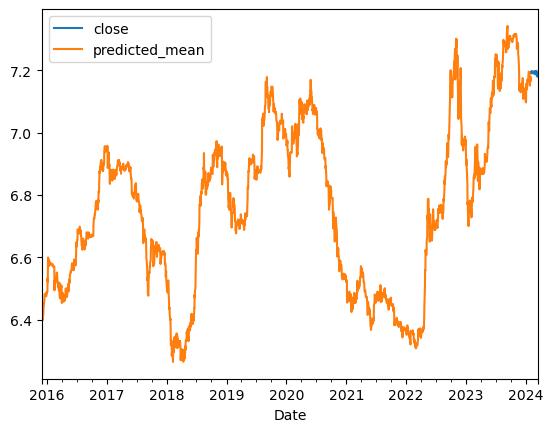

In [41]:
# train.plot(legend = True)
test.plot(legend = True)
predictions['2015-12-01':].plot(legend = True)